**Jupyter Kernel**:

* If you are in SageMaker Notebook instance, please make sure you are using **conda_pytorch_latest_p36** kernel
* If you are on SageMaker Studio, please make sure you are using **SageMaker JumpStart PyTorch 1.0** kernel

**Run All**:

* If you are in SageMaker notebook instance, you can go to *Cell tab -> Run All*
* If you are in SageMaker Studio, you can go to *Run tab -> Run All Cells*

**Note**: To *Run All* successfully, make sure you have executed the entire demo notebook `0_demo.ipynb` first.

## Training our Detector from Scratch

In this notebook, we will see how to train our detector from scratch

In [1]:
import json

import sagemaker
from sagemaker.s3 import S3Downloader

sagemaker_session = sagemaker.Session()
sagemaker_config = json.load(open("../stack_outputs.json"))
role = sagemaker_config["IamRole"]
solution_bucket = sagemaker_config["SolutionS3Bucket"]
region = sagemaker_config["AWSRegion"]
solution_name = sagemaker_config["SolutionName"]
bucket = sagemaker_config["S3Bucket"]

First, we download our **NEU-DET** dataset from our public S3 bucket

In [2]:
original_bucket = f"s3://{solution_bucket}-{region}/{solution_name}"
original_pretained_checkpoint = f"{original_bucket}/pretrained"
original_sources = f"{original_bucket}/build/lib/source_dir.tar.gz"

Note that for easiler data processing, we have already executed `prepare_data` once in our `0_demo.ipynb` and have already uploaded the prepared data to our S3 bucket

In [3]:
DATA_PATH = !echo $PWD/neu_det
DATA_PATH = DATA_PATH.n

After data preparation, we need to setup some paths that will be used throughtout the notebook

In [4]:
prefix = "neu-det"
neu_det_s3 = f"s3://{bucket}/{prefix}"
sources = f"{neu_det_s3}/code/"
train_output = f"{neu_det_s3}/output/"
neu_det_prepared_s3 = f"{neu_det_s3}/data/"
s3_checkpoint = f"{neu_det_s3}/checkpoint/"
sm_local_checkpoint_dir = "/opt/ml/checkpoints/"
s3_pretrained = f"{neu_det_s3}/pretrained/"

## Visualization

Let examine some datasets that we will use later by providing an `ID`

In [5]:
import copy
from typing import List

import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader

try:
    import sagemaker_defect_detection
except ImportError:
    import sys
    from pathlib import Path

    ROOT = Path("../src").resolve()
    sys.path.insert(0, str(ROOT))

from sagemaker_defect_detection import NEUDET, get_preprocess

SPLIT = "test"
ID = 50
dataset = NEUDET(DATA_PATH, split=SPLIT, preprocess=get_preprocess())
images, targets, _ = dataset[ID]
original_image = copy.deepcopy(images)
original_boxes = targets["boxes"].numpy().copy()
original_labels = targets["labels"].numpy().copy()
print(f"first images size: {original_image.shape}")
print(f"target bounding boxes: \n {original_boxes}")
print(f"target labels: {original_labels}")

first images size: torch.Size([3, 200, 200])
target bounding boxes: 
 [[132.   2. 177. 196.]]
target labels: [2]


And we can now visualize it using the provided utilities as follows

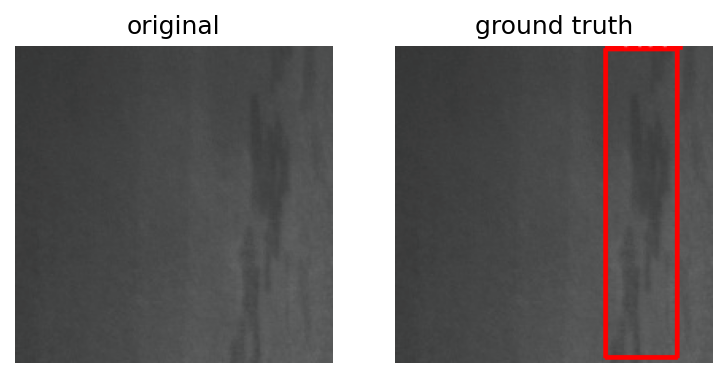

In [6]:
from sagemaker_defect_detection.utils.visualize import unnormalize_to_hwc, visualize

original_image_unnorm = unnormalize_to_hwc(original_image)

visualize(
    original_image_unnorm,
    [original_boxes],
    [original_labels],
    colors=[(255, 0, 0)],
    titles=["original", "ground truth"],
)

In order to get high **Mean Average Percision (mAP)** and **Mean Average Recall (mAR)** for **Intersection Over Union (IOU)** thresholds of 0.5 when training from scratch, it requires more than **300 epochs**. That is why we have provided a pretrained model and recommend finetuning whenever is possible. For demostration, we train the model from scratch for 10 epochs which takes about **16 minutes** and it results in the following mAP, mAR and the accumulated `main_score` of

* `Average Precision  (AP) @[ IoU=0.50:0.95 ] ~ 0.048`
* `Average Recall     (AR) @[ IoU=0.50:0.95] ~ 0.153`
* `main_score=0.0509`

To get higher mAP, mAR and overall `main_score`, you can train for more epochs

In [ ]:
%%time
import logging
from os import path as osp

from sagemaker.pytorch import PyTorch

NUM_CLASSES = 7  # 6 classes + 1 for background
BACKBONE = "resnet34"  # has to match the pretrained model backbone
assert BACKBONE in [
    "resnet34",
    "resnet50",
], "either resnet34 or resnet50. Make sure to be consistent with model_fn in detector.py"
EPOCHS = 10
LEARNING_RATE = 1e-3
SEED = 123

hyperparameters = {
    "backbone": BACKBONE,  # the backbone resnet model for feature extraction
    "num-classes": NUM_CLASSES,  # number of classes 6 + 1 background
    "epochs": EPOCHS,  # number of epochs to train
    "learning-rate": LEARNING_RATE,  # learning rate for optimizer
    "seed": SEED,  # random number generator seed
}

model = PyTorch(
    entry_point="detector.py",
    source_dir=osp.join(sources, "source_dir.tar.gz"),
    role=role,
    train_instance_count=1,
    train_instance_type="ml.g4dn.2xlarge",
    hyperparameters=hyperparameters,
    py_version="py3",
    framework_version="1.5",
    sagemaker_session=sagemaker_session,
    output_path=train_output,
    checkpoint_s3_uri=s3_checkpoint,
    checkpoint_local_path=sm_local_checkpoint_dir,
    # container_log_level=logging.DEBUG,
)

model.fit(neu_det_prepared_s3)

Then, we deploy our model which takes about **10 minutes** to complete

In [ ]:
%%time
detector = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=sagemaker_config["SolutionPrefix"] + "-detector-from-scratch-endpoint",
)

## Inference

We change the input depending on whether we are providing a list of images or a single image. Also the model requires a four dimensional array / tensor (with the first dimension as batch)

In [9]:
input = list(img.numpy() for img in images) if isinstance(images, list) else images.unsqueeze(0).numpy()

Now the input is ready and we can get some results

In [ ]:
%%time
predictions = detector.predict(input)

We use our `visualize` utility to check the detection results

In [ ]:
visualize(
    original_image_unnorm,
    [original_boxes, predictions[0]["boxes"]],
    [original_labels, predictions[0]["labels"]],
    colors=[(255, 0, 0), (0, 0, 255)],
    titles=["original", "ground truth", "trained from scratch"],
    dpi=200,
)

Here we want to compare the results of the new model and the pretrained model that we already deployed in `0_demo.ipynb`  visually by calling our endpoint from SageMaker runtime using `boto3`

In [ ]:
import boto3
import botocore

config = botocore.config.Config(read_timeout=200)
runtime = boto3.client("runtime.sagemaker", config=config)
payload = json.dumps(input.tolist() if isinstance(input, np.ndarray) else input)
response = runtime.invoke_endpoint(
    EndpointName=sagemaker_config["SolutionPrefix"] + "-demo-endpoint", ContentType="application/json", Body=payload
)
demo_predictions = json.loads(response["Body"].read().decode())

Finally, we compare the results of the provided pretrained model and our trained from scratch

In [ ]:
visualize(
    original_image_unnorm,
    [original_boxes, demo_predictions[0]["boxes"], predictions[0]["boxes"]],
    [original_labels, demo_predictions[0]["labels"], predictions[0]["labels"]],
    colors=[(255, 0, 0), (0, 0, 255), (127, 0, 127)],
    titles=["original", "ground truth", "pretrained", "from scratch"],
    dpi=250,
)

## Optional: Delete the endpoint and model

When you are done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [ ]:
detector.delete_model()
detector.delete_endpoint()

### [Click here to continue](./3_classification_from_scratch.ipynb)